# Imports and Data Preprocessing

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
books= pd.read_csv('books.csv',sep=";", on_bad_lines="skip", encoding='latin-1')
ratings= pd.read_csv('ratings.csv',sep=";", on_bad_lines="skip", encoding='latin-1')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21540\3417418560.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books= pd.read_csv('books.csv',sep=";", on_bad_lines="skip", encoding='latin-1')


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
books['Year-Of-Publication']=books['Year-Of-Publication'].astype(str)
books=books[books['Year-Of-Publication'].str.isdigit()]
books['Year-Of-Publication']=books['Year-Of-Publication'].astype(int)

# Visualizations 

Text(0, 0.5, 'Number of Publications')

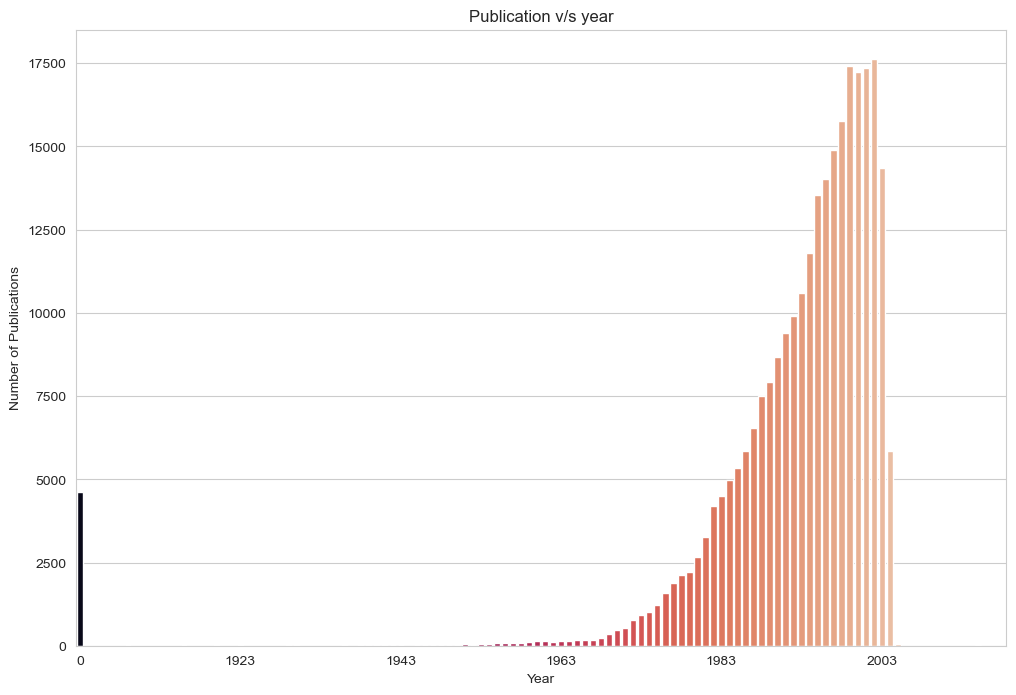

In [10]:
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
ax=sns.countplot(data=books, x='Year-Of-Publication', palette='rocket')
ax.set_xticks(ax.get_xticks()[::20])
plt.title('Publication v/s year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')

In [12]:
book_ratings= pd.merge(ratings, books, on='ISBN')
book_ratings.drop(columns=['Book-Author','Year-Of-Publication','Publisher','Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
book_ratings.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


Text(0, 0.5, 'Count')

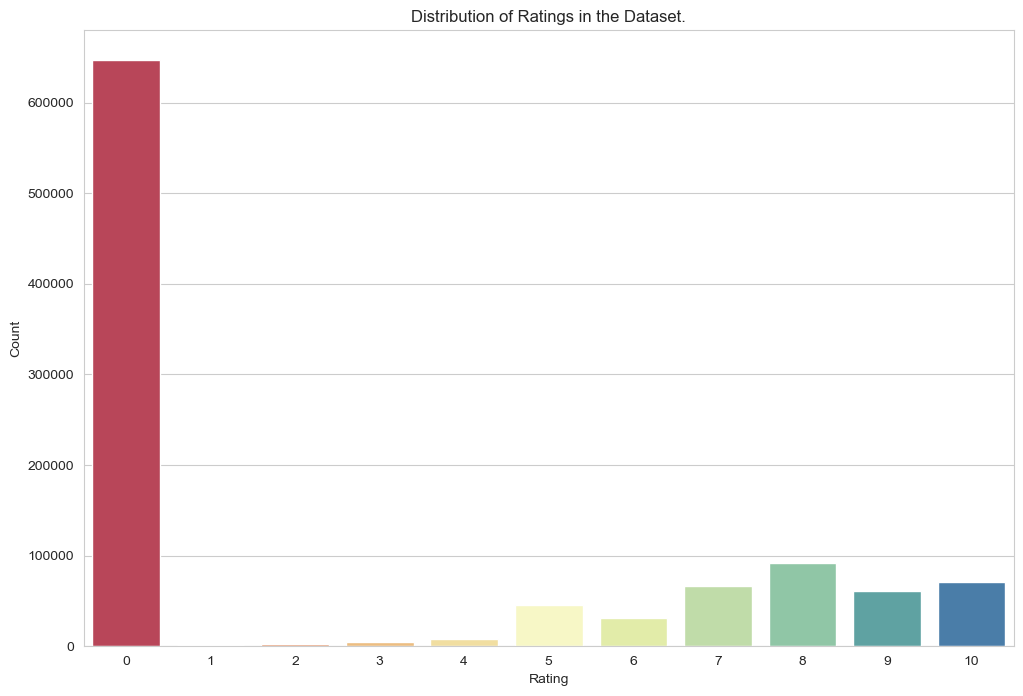

In [13]:
plt.figure(figsize=(12,8))
sns.countplot(data=book_ratings, x='Book-Rating', palette='Spectral')
plt.title('Distribution of Ratings in the Dataset.')
plt.xlabel('Rating')
plt.ylabel('Count')

In [14]:
book_rating_count= (book_ratings.
               groupby(by=['Book-Title'])['Book-Rating'].
               count().
               reset_index().
               rename(columns={'Book-Rating':'RatingCount'})
              )

book_rating_count.head()

,Book-Title,RatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [15]:
book_rating_count= book_rating_count.merge(book_ratings, left_on='Book-Title', right_on='Book-Title', how='left')

In [16]:
book_rating_count = book_rating_count.query('RatingCount >= 50')

In [17]:
# Working on a smaller sample to reduce computational requirements
book_rating_count=book_rating_count.sample(frac=0.2, random_state=33)

In [18]:
book_rating_count=book_rating_count.reset_index()

In [19]:
book_rating_count.head()

,index,Book-Title,RatingCount,User-ID,ISBN,Book-Rating
0,123771,Bridget Jones: The Edge of Reason,224,26487,0140298479,8
1,774902,The Emperor of Ocean Park (Today Show Book Clu...,96,136509,0375413634,0
2,851057,The Notebook,650,12824,0446676098,0
3,615419,Roses Are Red (Alex Cross Novels),230,219546,0446605484,0
4,546078,One for the Money (Stephanie Plum Novels (Pape...,291,252071,0061009059,0


<h3><b> Creating a User-Item Matrix </h3></b>

In [20]:
user_rating= book_rating_count.drop_duplicates(['User-ID', 'Book-Title'])
user_rating = user_rating.pivot(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

In [21]:
user_rating.head()

User-ID,8,16,17,39,44,67,99,114,176,183,...,278771,278773,278781,278782,278798,278832,278836,278843,278851,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
user_rating_matrix=csr_matrix(user_rating.values)

<h3><b> Training the Nearest Neighbors Model </h3></b>

In [23]:
model_knn= NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [24]:
dist, idx= model_knn.kneighbors(user_rating_matrix)

Text(0.5, 1.0, 'DIstribution of KNN Distances')

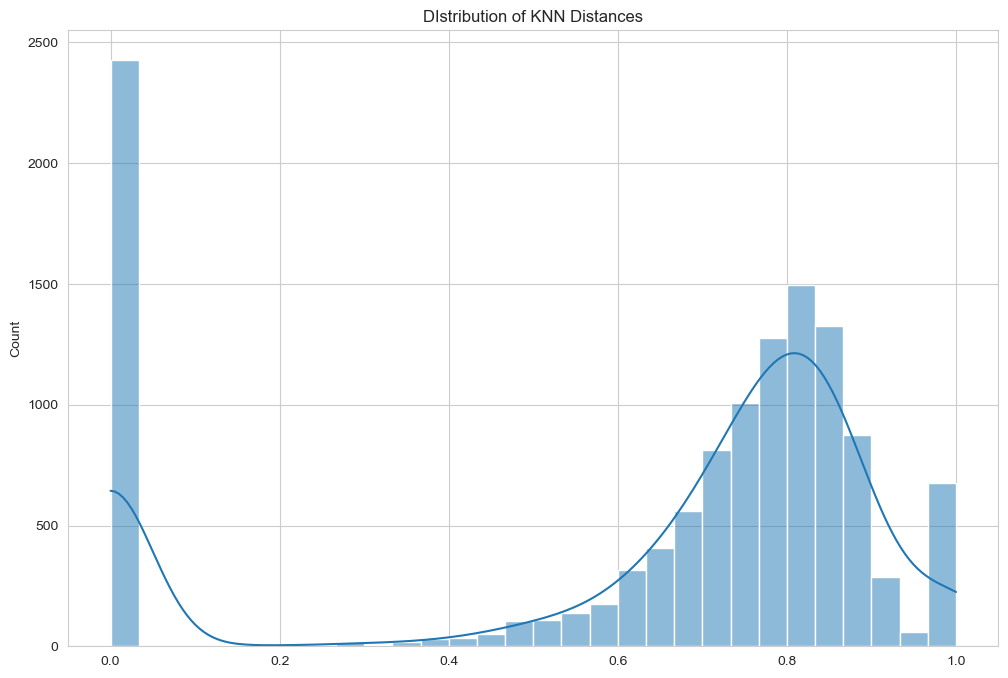

In [25]:
plt.figure(figsize=(12,8))
sns.histplot(dist.flatten(), bins=30, kde=True)
plt.title('DIstribution of KNN Distances')

<h3><b> Functions for Predicting Similar Books </h3></b>

In [26]:
list_of_books = user_rating.index.tolist()

In [34]:
def find_book(name):
            
    if name in list_of_books:
        return list_of_books.index(name)
    else:
        print("Suggestions for the book: ",name," are unavailable.")
        return False

In [32]:
def suggest(name):
    query_idx=find_book(name)
    if(query_idx==False):
        return
    else:
        dist, idx= model_knn.kneighbors(user_rating.iloc[query_idx,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(dist.flatten())):
        if i==0:
            print("Recommendation for {0} :\n".format(user_rating.index[query_idx]))
        else:
            print('{0}:{1}, with distance of {2}'.format(i, user_rating.index[idx.flatten()[i]], dist.flatten()[i]))

In [35]:
suggest("Here on Earth")

Recommendation for Here on Earth :

1:Cabin, with distance of 0.7795531212974222
2:Dr. Atkins' New Diet Revolution, with distance of 0.8141835020926695
3:Zoya, with distance of 0.8386841090289624
4:Seventh Heaven, with distance of 0.8652167425350941
5:Lily White, with distance of 0.8683996316388009
